In [1]:
import pandas as pd

#import sys
#sys.path.append('/home/debiani/local_dev/reis-app/src/lib')

from sentence_transformers import SentenceTransformer
import umap.umap_ as umap
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

%matplotlib inline

/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Dataframe

In [8]:
df_real = pd.read_excel('./ZBE-cat.xlsx')
# Limpiar nombres de columnas
df_real.columns = df_real.columns.str.strip().str.replace(r"\s+", " ", regex=True)
# Eliminar espacios al principio y al final de las celdas de texto
df_real = df_real.map(lambda x: x.strip() if isinstance(x, str) else x)

## Embeddings

In [3]:
def plot_clusters(embeddings, cluster_assignment, ax, title):
    # Convertir las categorías a valores numéricos
    cluster_assignment_numeric = pd.Categorical(cluster_assignment).codes
    cluster_names = pd.Categorical(cluster_assignment).categories

    # Reducir dimensiones con UMAP
    reducer = umap.UMAP(n_components=2, n_neighbors=5, min_dist=0.3, metric='cosine', random_state=42)
    reduced_embeds = reducer.fit_transform(embeddings)

    # Crear scatter plot en el subplot actual
    scatter = ax.scatter(reduced_embeds[:, 0], reduced_embeds[:, 1],
                         c=cluster_assignment_numeric, cmap='Spectral', s=10)
    ax.set_title(title)

    # Agregar leyenda para los nombres de los clusters
    handles = [plt.Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=scatter.cmap(scatter.norm(i)), markersize=5)
               for i in range(len(cluster_names))]
    ax.legend(handles, cluster_names, title="Clusters", bbox_to_anchor=(1.05, 1), loc='upper left')

In [4]:
def evaluate_clustering(embeddings, cluster_assignment):
    metrics = {}
    metrics['Calinski-Harabasz'] = calinski_harabasz_score(embeddings, cluster_assignment)
    metrics['Davies-Bouldin'] = davies_bouldin_score(embeddings, cluster_assignment)
    metrics['Silhouette'] = silhouette_score(embeddings, cluster_assignment, metric='cosine')
    
    return metrics

Batches: 100%|██████████| 3/3 [00:00<00:00,  3.09it/s]
/var/folders/47/0f50f7d96p5b7mhd9yfrspy40000gn/T/ipykernel_26455/1003131924.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat([
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
Batches: 100%|██████████| 3/3 [00:00<00:00,  7.84it/s]
/Users/thesportydar/local_d

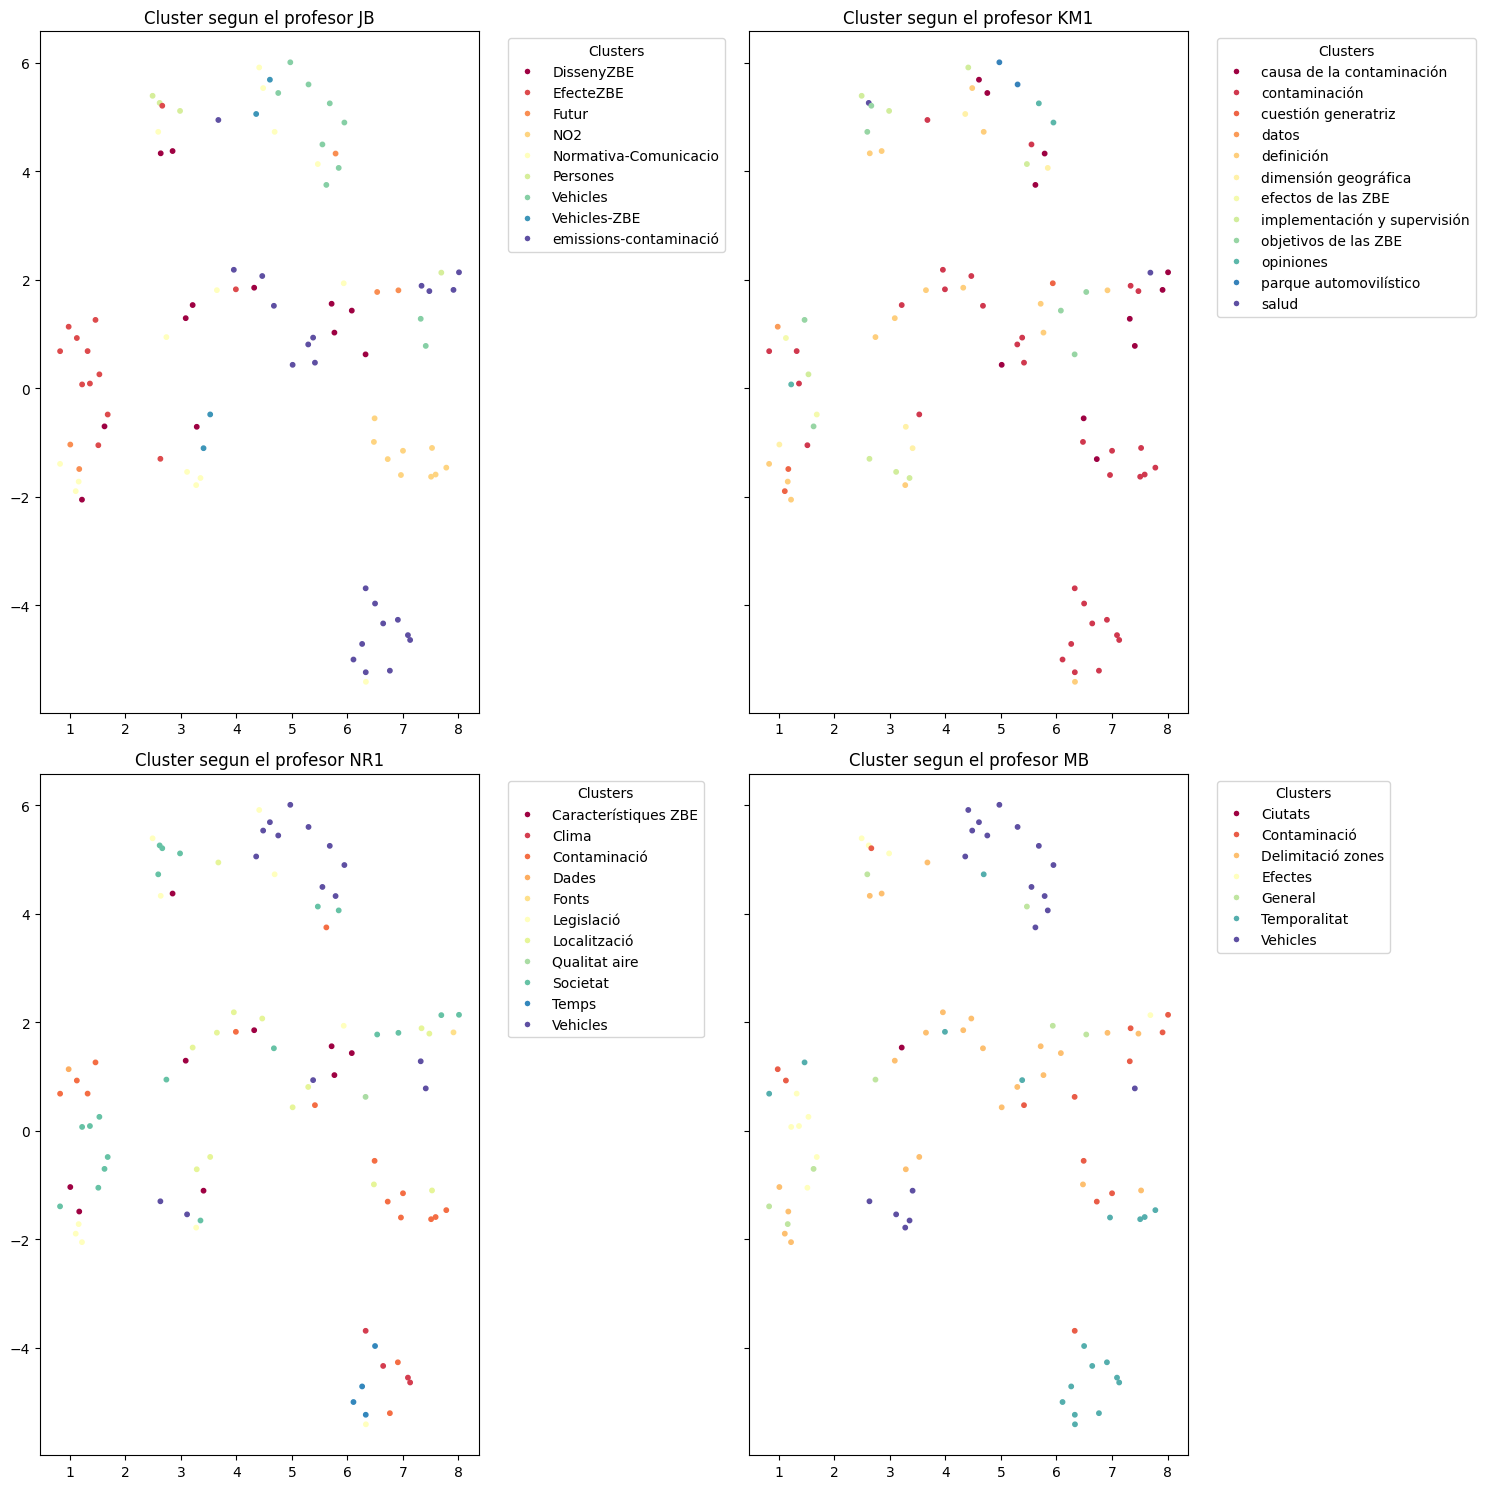

  Column  Calinski-Harabasz  Davies-Bouldin  Silhouette
0     JB           4.523788        2.508263    0.048703
1    KM1           2.114045        2.652408   -0.170707
2    NR1           2.646585        2.466171   -0.136273
3     MB           4.181443        2.834046    0.026372


In [28]:
# Crear un DataFrame vacío para almacenar las métricas
metrics_df = pd.DataFrame(columns=['Column', 'Calinski-Harabasz', 'Davies-Bouldin', 'Silhouette'])

cols = ['JB', 'KM1', 'NR1', 'MB']

# Configurar los subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 15), sharey=True)
axes = axes.flatten()  # Flatten the 2D array of axes for easier iteration

embedder_model = 'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2'
model = SentenceTransformer(embedder_model)

for i, col in enumerate(cols):
    ax = axes[i]
    embeddings = model.encode(df_real['Question'].tolist(), show_progress_bar=True)
    
    # Convertir las categorías a valores numéricos
    cluster_assignment = pd.Categorical(df_real[col]).codes
    
    # Evaluar el clustering
    metrics = evaluate_clustering(embeddings, cluster_assignment)
    
    # Agregar las métricas al DataFrame
    metrics_df = pd.concat([
        metrics_df,
        pd.DataFrame([{
            'Column': col,
            'Calinski-Harabasz': metrics['Calinski-Harabasz'],
            'Davies-Bouldin': metrics['Davies-Bouldin'],
            'Silhouette': metrics['Silhouette']
        }])
    ], ignore_index=True)

    # Graficar los clusters
    plot_clusters(
        embeddings,
        cluster_assignment=df_real[col].tolist(),
        ax=ax,
        title=f"Cluster segun el profesor {col}"
    )

plt.tight_layout()
plt.show()

# Imprimir todas las métricas al final
print(metrics_df)

In [29]:
for i, col in enumerate(cols):
    print(f"Distribución de {col}:")
    print(df_real[col].value_counts())
    print("\n")

Distribución de JB:
JB
emissions-contaminació    22
Normativa-Comunicacio     15
EfecteZBE                 13
DissenyZBE                12
Vehicles                  10
NO2                        9
Futur                      5
Persones                   4
Vehicles-ZBE               4
Name: count, dtype: int64


Distribución de KM1:
KM1
contaminación                   34
definición                      16
causa de la contaminación       11
implementación y supervisión     8
objetivos de las ZBE             7
dimensión geográfica             5
cuestión generatriz              3
opiniones                        3
efectos de las ZBE               2
salud                            2
parque automovilístico           2
datos                            1
Name: count, dtype: int64


Distribución de NR1:
NR1
Societat                20
Contaminació            16
Vehicles                15
Localització            13
Legislació              10
Característiques ZBE     9
Clima                    4
T

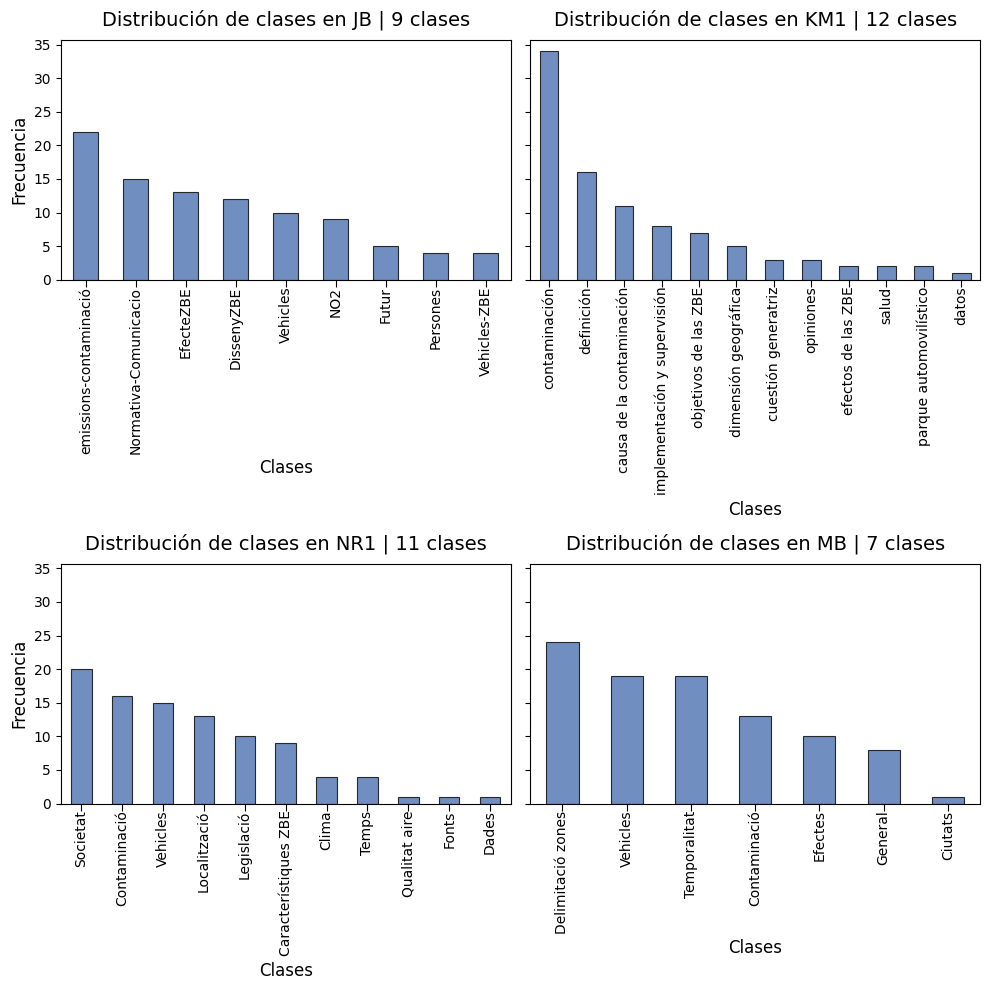

In [81]:
# Configurar subplots para las columnas
plt.style.use('seaborn-v0_8-pastel')
fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharey=True, dpi=100)
axes = axes.flatten()

# Iterar sobre las columnas y graficar la distribución de clases
for i, col in enumerate(cols):
    ax = axes[i]
    class_counts = df_real[col].value_counts().sort_values(ascending=False)
    bars = class_counts.plot(kind='bar', ax=ax, color='#4C72B0', edgecolor='black', linewidth=0.8, alpha=0.8)
    ax.set_title(f"Distribución de clases en {col} | {len(class_counts)} clases", fontsize=14, pad=10)
    ax.set_xlabel("Clases", fontsize=12)
    ax.set_ylabel("Frecuencia", fontsize=12)
    ax.tick_params(axis='x', rotation=90, labelsize=10, pad=0, length=5)



plt.tight_layout()
plt.show()
# save the figure
fig.savefig('distribucion_clases2.png', bbox_inches='tight', dpi=300)